In [41]:
import mne
import numpy as np
import pandas as pd
from scipy.signal import coherence, hilbert
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [17]:
pip install mne

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Luz María\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [31]:
# ====== CONFIGURACIÓN ======
edf_path = r"C:\Users\Luz María\OneDrive\Escritorio\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf"
sfreq_target = 256            # Frecuencia de muestreo a la que normalizamos (Hz)
fmin, fmax = 8, 13            # Banda alfa para la coherencia (puedes ajustar)

In [32]:
# ====== CARGA Y PREPROCESAMIENTO ======
raw = mne.io.read_raw_edf(edf_path, preload=True)
raw.resample(sfreq_target)
raw.filter(1., 45., fir_design='firwin')
data = raw.get_data()
ch_names = raw.info['ch_names']
n_channels = len(ch_names)

Extracting EDF parameters from C:\Users\Luz María\OneDrive\Escritorio\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\Luz María\AppData\Local\Temp\ipykernel_5576\1692581060.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Sampling frequency of the instance is already 256.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



In [7]:
data

array([[-6.26804381e-20,  9.96691423e-05,  1.56464544e-04, ...,
        -3.25461886e-05, -2.44063872e-05, -3.38813179e-21],
       [ 0.00000000e+00,  7.14210275e-05,  1.12391959e-04, ...,
        -5.47231902e-06, -1.78326784e-06, -1.10114283e-20],
       [-8.47032947e-21,  3.00249387e-05,  4.62387169e-05, ...,
         1.76838641e-05,  1.13131737e-05, -8.47032947e-22],
       ...,
       [-5.08219768e-20,  1.84483340e-04,  2.87170890e-04, ...,
         3.62255574e-05,  1.60453355e-05,  5.08219768e-21],
       [-1.10114283e-20, -6.40667792e-05, -1.01071351e-04, ...,
         7.34684870e-06,  1.44976840e-06, -1.27054942e-21],
       [ 1.86347248e-20, -3.08754614e-05, -4.79904833e-05, ...,
        -8.25147645e-06, -5.29050421e-06,  1.16467030e-21]],
      shape=(23, 921600))

In [8]:
ch_names

['FP1-F7',
 'F7-T7',
 'T7-P7',
 'P7-O1',
 'FP1-F3',
 'F3-C3',
 'C3-P3',
 'P3-O1',
 'FP2-F4',
 'F4-C4',
 'C4-P4',
 'P4-O2',
 'FP2-F8',
 'F8-T8',
 'T8-P8-0',
 'P8-O2',
 'FZ-CZ',
 'CZ-PZ',
 'P7-T7',
 'T7-FT9',
 'FT9-FT10',
 'FT10-T8',
 'T8-P8-1']

In [9]:
n_channels

23

In [33]:
# ====== 1. MATRIZ DE CORRELACIÓN DE PEARSON ======
corr_matrix = np.corrcoef(data)
corr_df = pd.DataFrame(corr_matrix, index=ch_names, columns=ch_names)
corr_df.to_csv("connectivity_pearson.csv")

# ====== 2. MATRIZ DE COHERENCIA ESPECTRAL ======
coh_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        f, Cxy = coherence(data[i], data[j], fs=sfreq_target, nperseg=sfreq_target*2)
        mask = (f >= fmin) & (f <= fmax)
        coh_matrix[i, j] = np.mean(Cxy[mask])

coh_df = pd.DataFrame(coh_matrix, index=ch_names, columns=ch_names)
coh_df.to_csv("connectivity_coherence.csv")

# ====== 3. MATRIZ DE PHASE LOCKING VALUE (PLV) ======
analytic_signal = hilbert(data)
phase_data = np.angle(analytic_signal)

plv_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        phase_diff = phase_data[i] - phase_data[j]
        plv_matrix[i, j] = np.abs(np.sum(np.exp(1j * phase_diff)) / phase_diff.size)

plv_df = pd.DataFrame(plv_matrix, index=ch_names, columns=ch_names)


In [34]:
corr_df.columns

Index(['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3',
       'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8',
       'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10',
       'FT10-T8', 'T8-P8-1'],
      dtype='object')

## Actividad de clase
1. Generar el mapa de calor de cada matriz de conectividad
2. Generar la distribución de datos de cada matriz de conectividad
3. ¿Qué valor se encuentra en el percentil 0.75 de cada matriz de conectividad?
4. Generar el grafo 2D de cada matriz de conectividad y compararlos
5. Generar el grafo 3D de cada matriz de conectividad y compararlos

<Axes: >

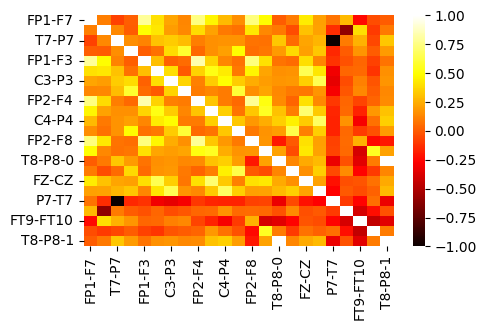

In [22]:
#Pearson
plt.figure(figsize=(5, 3))
sns.heatmap(corr_df, cmap='hot')

<Axes: >

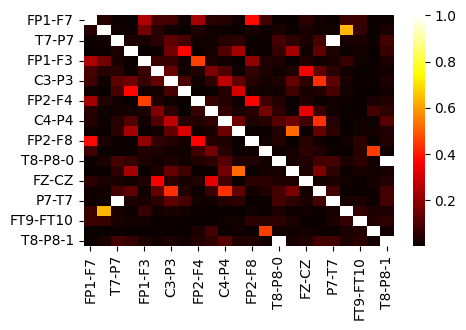

In [23]:
#Coherencia
plt.figure(figsize=(5, 3))
sns.heatmap(coh_df, cmap='hot')

<Axes: >

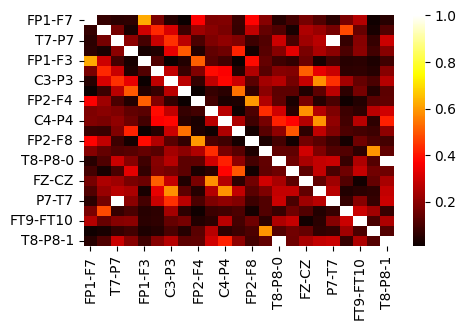

In [24]:
#Plv
plt.figure(figsize=(5, 3))
sns.heatmap(plv_df, cmap='hot')

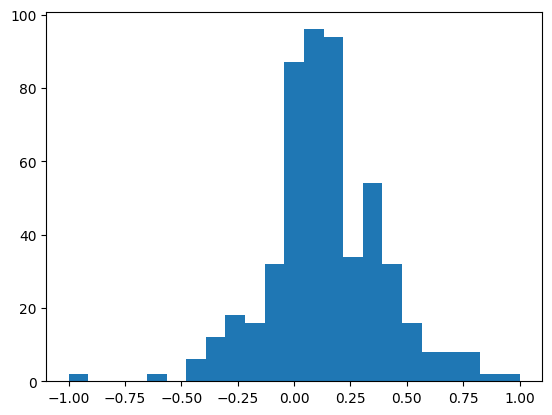

In [37]:
#Pearson
np.fill_diagonal(corr_df.values, 0)
corr_df_plano = corr_df.values.flatten().tolist()
plt.hist(corr_df_plano, bins=23)
plt.show()

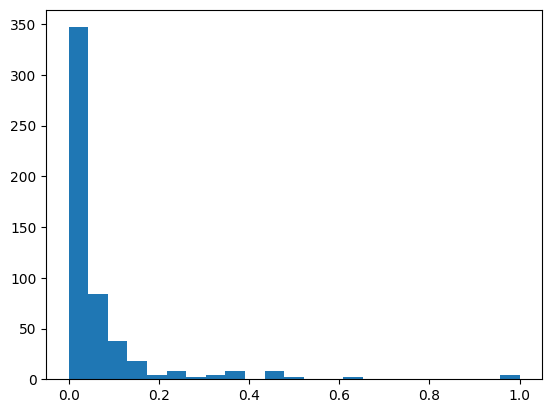

In [38]:
#Coherencia
np.fill_diagonal(coh_df.values, 0)
coh_df_plano = coh_df.values.flatten().tolist()
plt.hist(coh_df_plano, bins=23)
plt.show()

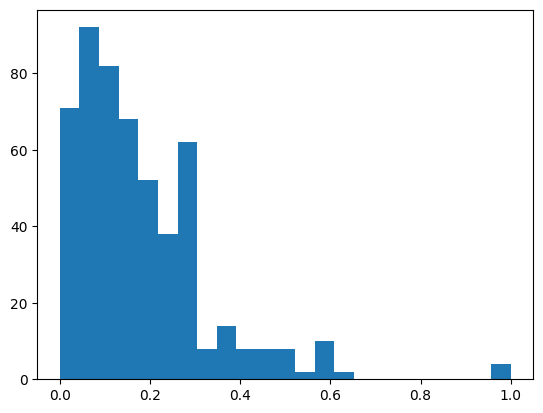

In [39]:
#plv
np.fill_diagonal(plv_df.values, 0)
plv_df_plano = plv_df.values.flatten().tolist()
plt.hist(plv_df_plano, bins=23)
plt.show()

### ¿Qué valor se encuentra en el percentil 75 de cada gráfica?
- pearson: 0.29180182781081676
- coh: 0.0638915786246104
- plv: 0.256082330777383

In [47]:
percentil_75_pearson = np.percentile(corr_df_plano, 75)
percentil_75_pearson

np.float64(0.29180182781081676)

In [48]:
percentil_75_coh = np.percentile(coh_df_plano, 75)
percentil_75_coh

np.float64(0.0638915786246104)

In [49]:
percentil_75_plv = np.percentile(plv_df_plano, 75)
percentil_75_plv

np.float64(0.256082330777383)

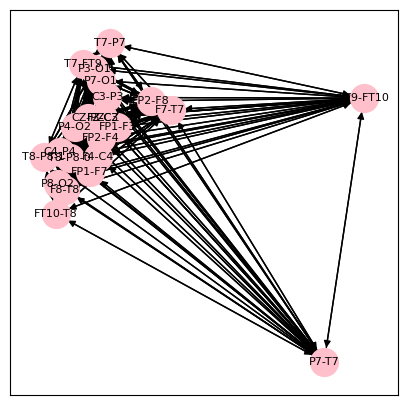

In [42]:
#Pearson
grafo = nx.from_pandas_adjacency(corr_df, create_using=nx.DiGraph)
pos = nx.spring_layout(grafo)
plt.figure(figsize=(5,5))
nx.draw_networkx(grafo, pos, with_labels=True, 
                 node_color='pink', arrows=True, 
                 node_size=400, font_size=8)
plt.show()

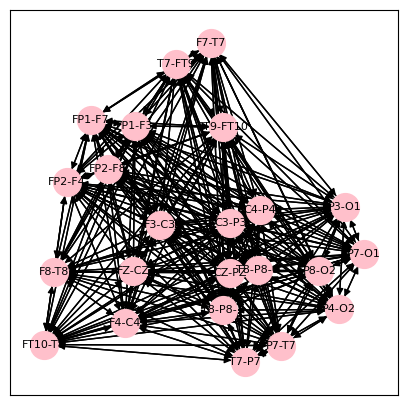

In [51]:
#Coherencia
grafo = nx.from_pandas_adjacency(coh_df, create_using=nx.DiGraph)
pos = nx.spring_layout(grafo)
plt.figure(figsize=(5,5))
nx.draw_networkx(grafo, pos, with_labels=True, 
                 node_color='pink', arrows=True, 
                 node_size=400, font_size=8)
plt.show()

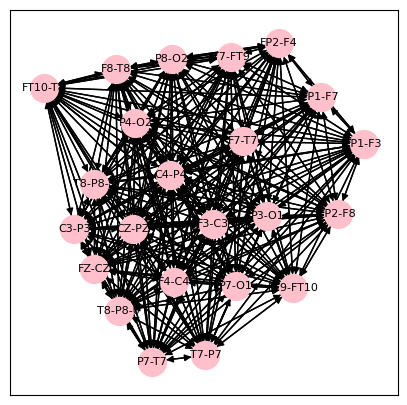

In [46]:
#plv
grafo = nx.from_pandas_adjacency(plv_df, create_using=nx.DiGraph)
pos = nx.spring_layout(grafo)
plt.figure(figsize=(5,5))
nx.draw_networkx(grafo, pos, with_labels=True, 
                 node_color='pink', arrows=True, 
                 node_size=400, font_size=8)
plt.show()